In [17]:
from __future__ import print_function
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Concatenate
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input
from keras import backend as K
from keras.models import load_model
import pickle
import pandas as pd
import re
import numpy as np
import random
from keras.utils.vis_utils import plot_model
import keras.callbacks
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import datasets, linear_model
import seaborn as sns
from numpy.random import seed; seed(123)
import tensorflow as tf; tf.random.set_seed(123)
from sklearn.metrics import roc_auc_score
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeRegressor

In [18]:
##### load data #####
processed_data = pickle.load( open( "result_04_processed_data_no_scale_Final.obj", "rb" ) )
cytof_files = processed_data["cytof_files"]
cytof_files.to_csv("result_11_cytof_files.csv")
expr_list = processed_data["expr_list"]

r1 = [t1==t1 for t1 in cytof_files.CMV_Ab] 
cytof_files = cytof_files.loc[r1,:]
expr_list = expr_list[r1]#[expr_list[i] for i in range(len(expr_list)) if r1[i]==True]
print(expr_list.shape)

#marker_names = expr_list[0].columns.tolist()
#marker_names.remove('TIME')
#display(expr_list[0].head())
#print(marker_names)

(532, 10000, 27, 1)


In [3]:
cytof_files.head()
len(set(cytof_files.name.values))

472

In [4]:
y = cytof_files.CMV_Ab.values> 2
x = expr_list

(array([242.,  39.,   3.,  29.,  38.,  67.,  61.,  39.,   8.,   6.]),
 array([-0.6,  0.4,  1.4,  2.4,  3.4,  4.4,  5.4,  6.4,  7.4,  8.4,  9.4]),
 <a list of 10 Patch objects>)

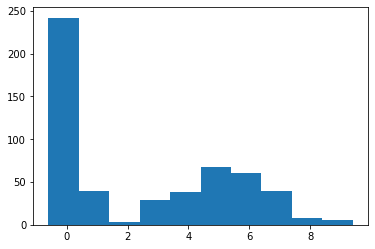

In [5]:
# look at CMV_Ab distribution
plt.hist(cytof_files.CMV_Ab.values)

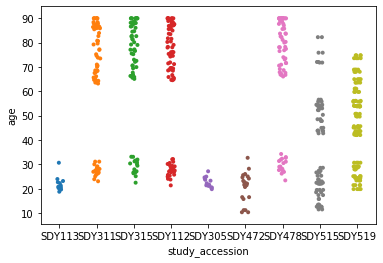

In [6]:
##### look at age distribution #####
sns.stripplot(x="study_accession", y="age", data=cytof_files,
              size=4, jitter=True, edgecolor="gray")

In [7]:
##### split train, validation and test######
train_id = [i for i in range(len(x)) if cytof_files.study_accession.iloc[i] not in ["SDY515","SDY519"]]
valid_id = [i for i in range(len(x)) if cytof_files.study_accession.iloc[i]=="SDY515"]
test_id = [i for i in range(len(x)) if cytof_files.study_accession.iloc[i]=="SDY519"]

x_train = x[train_id]
x_valid = x[valid_id]
x_test = x[test_id]

y_train = y[train_id]
y_valid = y[valid_id]
y_test = y[test_id]

In [8]:
##### define model #####
model_input = Input(shape=x_train[0].shape)
model_output = Conv2D(5, kernel_size=(1, x_train.shape[2]),
                 activation=None)(model_input)
#model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)
model_output = Dropout(0.2)(model_output)

#model_output = Conv2D(3, (1, 1), activation=None)(model_output)
#model_output = BatchNormalization()(model_output)
#model_output = Activation("relu")(model_output)

model_output = MaxPooling2D(pool_size=(10000, 1))(model_output)
model_output = Flatten()(model_output)

#model_output = Dense(3, activation=None)(model_output)
#model_output = BatchNormalization()(model_output)
#model_output = Activation("relu")(model_output)
model_output = Dense(1, activation=None)(model_output)
#model_output = BatchNormalization()(model_output)
model_output = Activation("sigmoid")(model_output)

model = keras.models.Model(inputs=[model_input],
                           outputs=model_output)
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath='result_11_weights.hdf5', monitor='val_loss', 
                                               verbose=0, save_best_only=True)
earlyStop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.00000001, patience=100, 
                                          verbose=0, mode='auto', baseline=None, restore_best_weights=True)

model.fit([x_train], y_train,
          batch_size=60,
          epochs=5000,
          verbose=1,
          callbacks=[checkpointer,earlyStop],
          validation_data=([x_valid], y_valid))


Train on 333 samples, validate on 79 samples
Epoch 1/500
333/333 [==============================] - 2s 5ms/step - loss: 2.7276 - accuracy: 0.5075 - val_loss: 1.8394 - val_accuracy: 0.5443
Epoch 2/500
333/333 [==============================] - 1s 4ms/step - loss: 2.2678 - accuracy: 0.5075 - val_loss: 1.5152 - val_accuracy: 0.5443
Epoch 3/500
333/333 [==============================] - 1s 4ms/step - loss: 1.8354 - accuracy: 0.5075 - val_loss: 1.2357 - val_accuracy: 0.5443
Epoch 4/500
333/333 [==============================] - 1s 4ms/step - loss: 1.4761 - accuracy: 0.5075 - val_loss: 1.0144 - val_accuracy: 0.5443
Epoch 5/500
333/333 [==============================] - 1s 4ms/step - loss: 1.1589 - accuracy: 0.5075 - val_loss: 0.8620 - val_accuracy: 0.5443
Epoch 6/500
333/333 [==============================] - 1s 4ms/step - loss: 0.9344 - accuracy: 0.5075 - val_loss: 0.7735 - val_accuracy: 0.5190
Epoch 7/500
333/333 [==============================] - 1s 4ms/step - loss: 0.7990 - accuracy: 0.5

Epoch 114/500
333/333 [==============================] - 1s 4ms/step - loss: 0.5256 - accuracy: 0.7868 - val_loss: 0.6277 - val_accuracy: 0.6456
Epoch 115/500
333/333 [==============================] - 1s 4ms/step - loss: 0.5249 - accuracy: 0.7898 - val_loss: 0.6316 - val_accuracy: 0.6709
Epoch 116/500
333/333 [==============================] - 1s 4ms/step - loss: 0.5245 - accuracy: 0.7868 - val_loss: 0.6292 - val_accuracy: 0.6456
Epoch 117/500
333/333 [==============================] - 1s 4ms/step - loss: 0.5258 - accuracy: 0.7688 - val_loss: 0.6239 - val_accuracy: 0.6456
Epoch 118/500
333/333 [==============================] - 1s 4ms/step - loss: 0.5233 - accuracy: 0.7658 - val_loss: 0.6257 - val_accuracy: 0.6456
Epoch 119/500
333/333 [==============================] - 1s 4ms/step - loss: 0.5247 - accuracy: 0.7658 - val_loss: 0.6271 - val_accuracy: 0.6456
Epoch 120/500
333/333 [==============================] - 1s 4ms/step - loss: 0.5260 - accuracy: 0.7748 - val_loss: 0.6254 - val_ac

333/333 [==============================] - 1s 4ms/step - loss: 0.4221 - accuracy: 0.8408 - val_loss: 0.5851 - val_accuracy: 0.6582
Epoch 227/500
333/333 [==============================] - 1s 4ms/step - loss: 0.4258 - accuracy: 0.8468 - val_loss: 0.5752 - val_accuracy: 0.6835
Epoch 228/500
333/333 [==============================] - 1s 4ms/step - loss: 0.4183 - accuracy: 0.8078 - val_loss: 0.5706 - val_accuracy: 0.6835
Epoch 229/500
333/333 [==============================] - 1s 4ms/step - loss: 0.4180 - accuracy: 0.8198 - val_loss: 0.5824 - val_accuracy: 0.6709
Epoch 230/500
333/333 [==============================] - 1s 4ms/step - loss: 0.4186 - accuracy: 0.8438 - val_loss: 0.5852 - val_accuracy: 0.6456
Epoch 231/500
333/333 [==============================] - 1s 4ms/step - loss: 0.4188 - accuracy: 0.8228 - val_loss: 0.5763 - val_accuracy: 0.6962
Epoch 232/500
333/333 [==============================] - 1s 4ms/step - loss: 0.4163 - accuracy: 0.8138 - val_loss: 0.5771 - val_accuracy: 0.6962

333/333 [==============================] - 1s 4ms/step - loss: 0.3683 - accuracy: 0.8438 - val_loss: 0.5759 - val_accuracy: 0.6709
Epoch 339/500
333/333 [==============================] - 1s 4ms/step - loss: 0.3566 - accuracy: 0.8589 - val_loss: 0.5715 - val_accuracy: 0.6709
Epoch 340/500
333/333 [==============================] - 1s 4ms/step - loss: 0.3634 - accuracy: 0.8589 - val_loss: 0.5698 - val_accuracy: 0.6835
Epoch 341/500
333/333 [==============================] - 1s 4ms/step - loss: 0.3595 - accuracy: 0.8559 - val_loss: 0.5649 - val_accuracy: 0.6962
Epoch 342/500
333/333 [==============================] - 1s 4ms/step - loss: 0.3631 - accuracy: 0.8438 - val_loss: 0.5724 - val_accuracy: 0.6709
Epoch 343/500
333/333 [==============================] - 1s 4ms/step - loss: 0.3534 - accuracy: 0.8739 - val_loss: 0.5722 - val_accuracy: 0.6709
Epoch 344/500
333/333 [==============================] - 1s 4ms/step - loss: 0.3667 - accuracy: 0.8348 - val_loss: 0.5701 - val_accuracy: 0.6835

333/333 [==============================] - 1s 4ms/step - loss: 0.3167 - accuracy: 0.8649 - val_loss: 0.5662 - val_accuracy: 0.6709
Epoch 451/500
333/333 [==============================] - 1s 4ms/step - loss: 0.3323 - accuracy: 0.8589 - val_loss: 0.5651 - val_accuracy: 0.6709
Epoch 452/500
333/333 [==============================] - 1s 4ms/step - loss: 0.3212 - accuracy: 0.8709 - val_loss: 0.5675 - val_accuracy: 0.6709
Epoch 453/500
333/333 [==============================] - 1s 4ms/step - loss: 0.3242 - accuracy: 0.8559 - val_loss: 0.5693 - val_accuracy: 0.6835
Epoch 454/500
333/333 [==============================] - 1s 4ms/step - loss: 0.3193 - accuracy: 0.8829 - val_loss: 0.5647 - val_accuracy: 0.6709
Epoch 455/500
333/333 [==============================] - 1s 4ms/step - loss: 0.3257 - accuracy: 0.8679 - val_loss: 0.5643 - val_accuracy: 0.6709
Epoch 456/500
333/333 [==============================] - 1s 4ms/step - loss: 0.3262 - accuracy: 0.8589 - val_loss: 0.5719 - val_accuracy: 0.6962

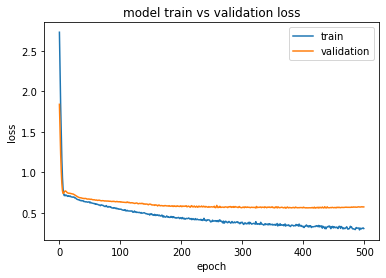

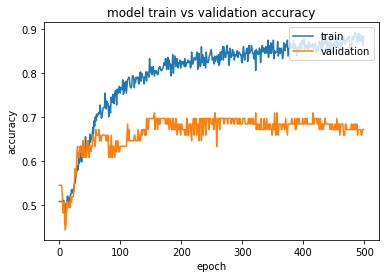

In [9]:
# plot train and validation loss
#model.save('result_11_weights.hdf5')

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [8]:
best_model = load_model('result_11_weights.hdf5')

# print result of the best model
score = best_model.evaluate([x_train], y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = best_model.evaluate([x_valid], y_valid, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])

score = best_model.evaluate([x_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.36145595208302633
Train accuracy: 0.8708708882331848
Valid loss: 0.5601946643636196
Valid accuracy: 0.6962025165557861
Test loss: 1.0397953192392986
Test accuracy: 0.44999998807907104


In [9]:
y_true = y_test
y_scores = best_model.predict([x_test])
print(roc_auc_score(y_true, y_scores))

with open("result_11_cellCNN_ROC.obj", "wb") as f:
    pickle.dump({"true":y_true,"score":y_scores}, f)

y_true = y_train
y_scores = best_model.predict([x_train])
print(roc_auc_score(y_true, y_scores))

y_true = y_valid
y_scores = best_model.predict([x_valid])
print(roc_auc_score(y_true, y_scores))


0.8452380952380952
0.9484774137682206
0.7810077519379844
